In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import timeit


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from sklearn import svm
import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from fastai import *
from fastai.tabular import *
from fastai.callbacks.tracker import SaveModelCallback

# **Practical Motivation - Costs of Credit Card Fraud to Banks and Customers**

Despite the intriduction of EMV chip technology, credit card fraud remains a concern for both banks and customers. In 2016, global card fraud losses equaled $22.8 billion, with 15.4 million consumers becoming victims of identity theft or fraud.

**Loss to customers**

Customers lose money as a result from credit card frauds. The average U.S. consumer lost a median of $429 from credit card fraud in 2017.

Customers also experience identity theft which can result in inconveniences such as account seizures.

**Loss to banks**

Most of the financial loss is not attributed to the customers but to the financial institutions (79% of credit card fraud losses are paid by the financial institutions).


Banks may also face penalties if they fail to curb the high frequencies of credit card fraud. This is practised in Australia where the new Australia Payments Network sets a minimum loss thresholds and intervention trigger points for financial institutions and imposes penalties if they fail to meet these thresholds.





In [0]:
df = pd.read_csv("drive/My Drive/creditcard.csv")

# **Problem Formulation - Binary Classification on Transactions to determine if they are fraudulent**

Dataframe consists of continuous variables V1-V28, transaction amount and transaction time

The fraud column is a binary of 1 or 0. 1 indicating that it is fraudulent and 0 indicating that it is not.

Given a test dataset without the Class column, we need to determine if that particular transaction is fraudulent

In [0]:
# Binary class
df['Class'].unique()

array([0, 1])

In [0]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# **Statistical Description**

*   Check for Null Values
*   Feature Engineering for Neural Network Implementation 
*   Check data types
*   Understanding range and quartiles of variables




In [0]:
# Checking for null
print("There are ", df.isnull().sum().sum(), "null values in the dataset")

There are  0 null values in the dataset


In [0]:
indices = range(0,len(df))
train_df, test_df, indices_train, indices_test = train_test_split(df, indices, test_size=0.2, stratify=df['Class'])

In [0]:
# Feature Engineering
def normalise_and_generate_features(train_df, test_df):

  time_between_transactions = list(train_df.Time.diff())
  time_between_transactions[0] = 0
  train_df['time_between_transactions'] = time_between_transactions

  time_between_transactions = list(test_df.Time.diff())
  time_between_transactions[0] = 0
  test_df['time_between_transactions'] = time_between_transactions

  train_values = train_df['Class']
  test_values = test_df['Class']

  normalized_test_df=(test_df-train_df.mean())/train_df.std()
  normalized_test_df['Class'] = test_values

  normalized_train_df=(train_df-train_df.mean())/train_df.std()
  normalized_train_df['Class'] = train_values

  dfs = [normalized_train_df, normalized_test_df]

  for df in dfs:
    for i in range(1,29):
      df['V' +str(i)+"Mean"] = df['V'+str(i)].mean()
      df['V' +str(i)+"STD"] = df['V'+str(i)].std()
      df['V' +str(i)+"Skew"] = df['V'+str(i)].skew()
      df['V' +str(i)+"Kurtosis"] = df['V'+str(i)].kurtosis()
  return normalized_train_df,normalized_test_df

train_df, test_df = normalise_and_generate_features(train_df, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
# Checking Data types
train_df.dtypes

Time           float64
V1             float64
V2             float64
V3             float64
V4             float64
                ...   
V27Kurtosis    float64
V28Mean        float64
V28STD         float64
V28Skew        float64
V28Kurtosis    float64
Length: 144, dtype: object

In [0]:
# Understanding Range and Quartiles
train_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time_between_transactions,V1Mean,V1STD,V1Skew,V1Kurtosis,V2Mean,V2STD,V2Skew,V2Kurtosis,...,V19Mean,V19STD,V19Skew,V19Kurtosis,V20Mean,V20STD,V20Skew,V20Kurtosis,V21Mean,V21STD,V21Skew,V21Kurtosis,V22Mean,V22STD,V22Skew,V22Kurtosis,V23Mean,V23STD,V23Skew,V23Kurtosis,V24Mean,V24STD,V24Skew,V24Kurtosis,V25Mean,V25STD,V25Skew,V25Kurtosis,V26Mean,V26STD,V26Skew,V26Kurtosis,V27Mean,V27STD,V27Skew,V27Kurtosis,V28Mean,V28STD,V28Skew,V28Kurtosis
count,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,227845.000000,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,...,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05
mean,1.006312e-17,-4.982153e-17,-2.267955e-17,1.763922e-18,-1.171302e-17,-1.922334e-17,-1.630799e-17,-1.052554e-17,3.696147e-17,1.135790e-16,-6.273616e-18,-6.388125e-18,-4.509256e-17,-1.777175e-17,1.684204e-17,-7.223844e-17,5.553248e-17,3.752670e-17,5.675954e-17,8.240608e-18,-5.949021e-17,9.503737e-18,-2.767700e-19,-4.346873e-17,-1.236633e-18,2.283937e-17,4.687500e-17,1.160875e-17,1.160924e-18,6.587119e-14,0.001729,-2.192818e-17,-4.982153e-17,1.000000e+00,-3.330093e+00,3.376372e+01,-2.267955e-17,1.000000e+00,-4.866682e+00,1.034249e+02,...,8.240608e-18,1.000000e+00,1.098993e-01,1.737407e+00,-5.949021e-17,1.000000e+00,-2.119210e+00,3.002470e+02,9.503737e-18,1.000000e+00,3.749274e+00,1.864602e+02,-2.767700e-19,1.000000e+00,-2.221645e-01,2.724865e+00,-4.346873e-17,1.000000e+00,-6.665830e+00,4.758073e+02,-1.236633e-18,1.000000e+00,-5.542939e-01,6.206561e-01,2.283937e-17,1.000000e+00,-4.383828e-01,4.583257e+00,4.687500e-17,1.000000e+00,5.743206e-01,9.245286e-01,1.160875e-17,1.000000e+00,-8.751387e-01,2.784262e+02,1.160924e-18,1.000000e+00,1.091104e+01,9.362640e+02
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.041548,1.000000e+00,2.614525e-28,1.010305e-14,1.561021e-11,5.472612e-11,4.188368e-29,1.632031e-14,8.694398e-12,4.621806e-10,...,3.999780e-30,4.996015e-15,2.670925e-13,6.408443e-12,2.823265e-28,9.103849e-15,7.905249e-12,3.626050e-10,3.790238e-30,4.218857e-15,4.356969e-12,2.779365e-10,1.140394e-30,9.992029e-16,7.248662e-13,1.273562e-11,8.268267e-29,3.663744e-15,3.251717e-11,5.970846e-10,5.194630e-30,1.709747e-14,1.627480e-12,2.024052e-12,2.827271e-29,1.776361e-15,1.731619e-12,2.738704e-11,7.059704e-29,2.409189e-14,2.040039e-12,2.816753e-12,6.185638e-29,4.440902e-15,3.335783e-12,1.166600e-09,4.744346e-30,2.242655e-14,1.099567e-11,1.785456e-09
min,-1.997366e+00,-2.877362e+01,-4.385961e+01,-3.183688e+01,-4.012493e+00,-8.242883e+01,-1.964683e+01,-3.520567e+01,-4.306798e+01,-1.211028e+01,-2.250978e+01,-4.699665e+00,-1.867670e+01,-4.024711e+00,-2.002836e+01,-4.915682e+00,-1.610380e+01,-2.829377e+01,-1.113161e

# **Pattern Recognition**

*   Countplot of Class variable
*   Boxplot of V1-V28 against Class
*   Correlation Heatmap



No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

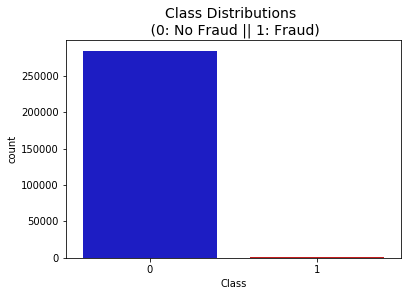

In [0]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Due to the imbalanced dataset, we can either undersample or oversample the train_df

Creating undersampled dataset and oversampled dataset

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


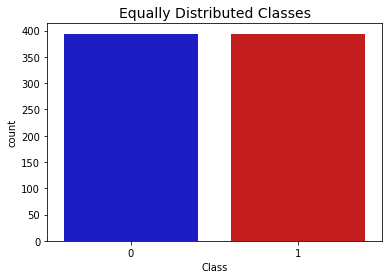

In [0]:
# Undersampled Dataframe

df = df.sample(frac=1)
# amount of fraud classes 492 rows.
fraud_df = train_df.loc[train_df['Class'] == 1]
non_fraud_df = train_df.loc[train_df['Class'] == 0][:len(fraud_df)]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
undersample_df = normal_distributed_df.sample(frac=1, random_state=42)

print('Distribution of the Classes in the subsample dataset')
print(undersample_df['Class'].value_counts()/len(undersample_df))

sns.countplot('Class', data=undersample_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


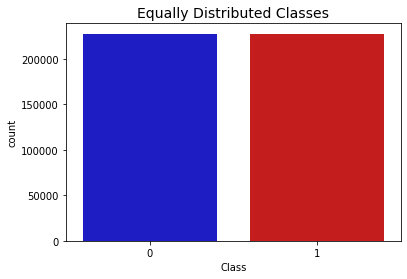

In [0]:
# Oversampled Dataframe
from imblearn.over_sampling import SMOTE

df = df.sample(frac=1)
sm = SMOTE(ratio='minority', random_state=42)
oversample_x, oversample_y = sm.fit_sample(train_df.drop('Class', axis=1), train_df['Class'])
oversample_x = pd.DataFrame(oversample_x, columns = train_df.drop('Class', axis=1).columns)
oversample_y = pd.DataFrame(oversample_y, columns = ['Class'])
oversample_df = pd.concat([oversample_x, oversample_y], axis=1)

print('Distribution of the Classes in the subsample dataset')
print(oversample_df['Class'].value_counts()/len(oversample_df))

sns.countplot('Class', data=oversample_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

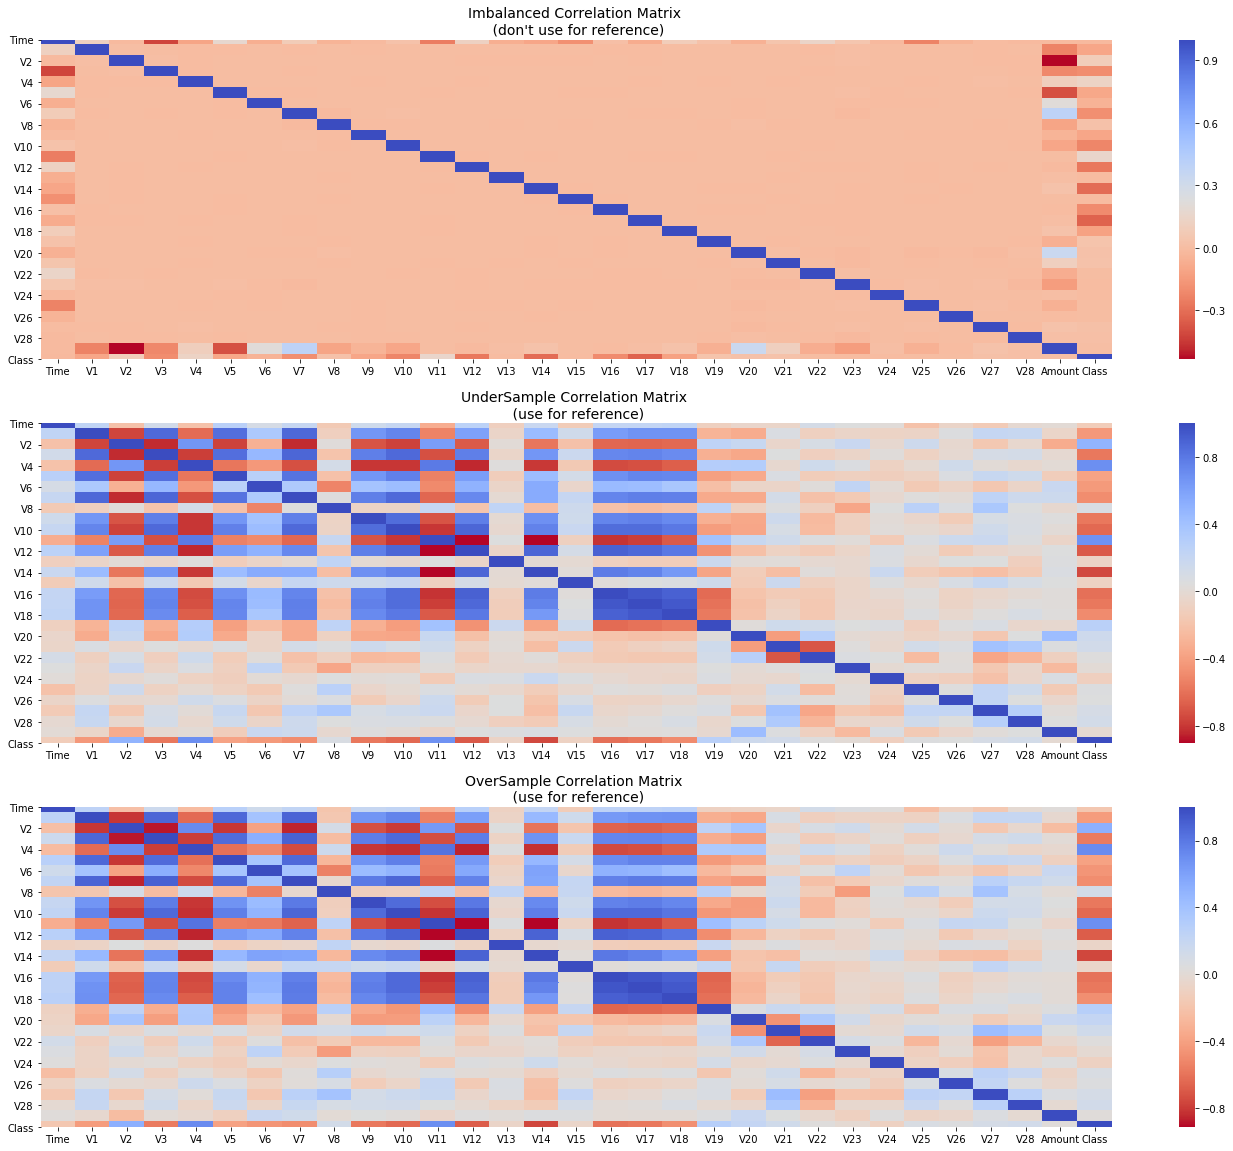

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,20))

# Entire DataFrame
corr = train_df[train_df.columns[:31]].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = undersample_df[train_df.columns[:31]].corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('UnderSample Correlation Matrix \n (use for reference)', fontsize=14)

over_sample_corr = oversample_df[train_df.columns[:31]].corr()
sns.heatmap(over_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax3)
ax3.set_title('OverSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

As seen above, the correlation matrix for our imbalanced train_df is unreflective of the correlations between my variables (V1-V28, Time, Amount) and my target (Class). Hence, we decide to fit a model either on our undersampled_df or oversampled_df

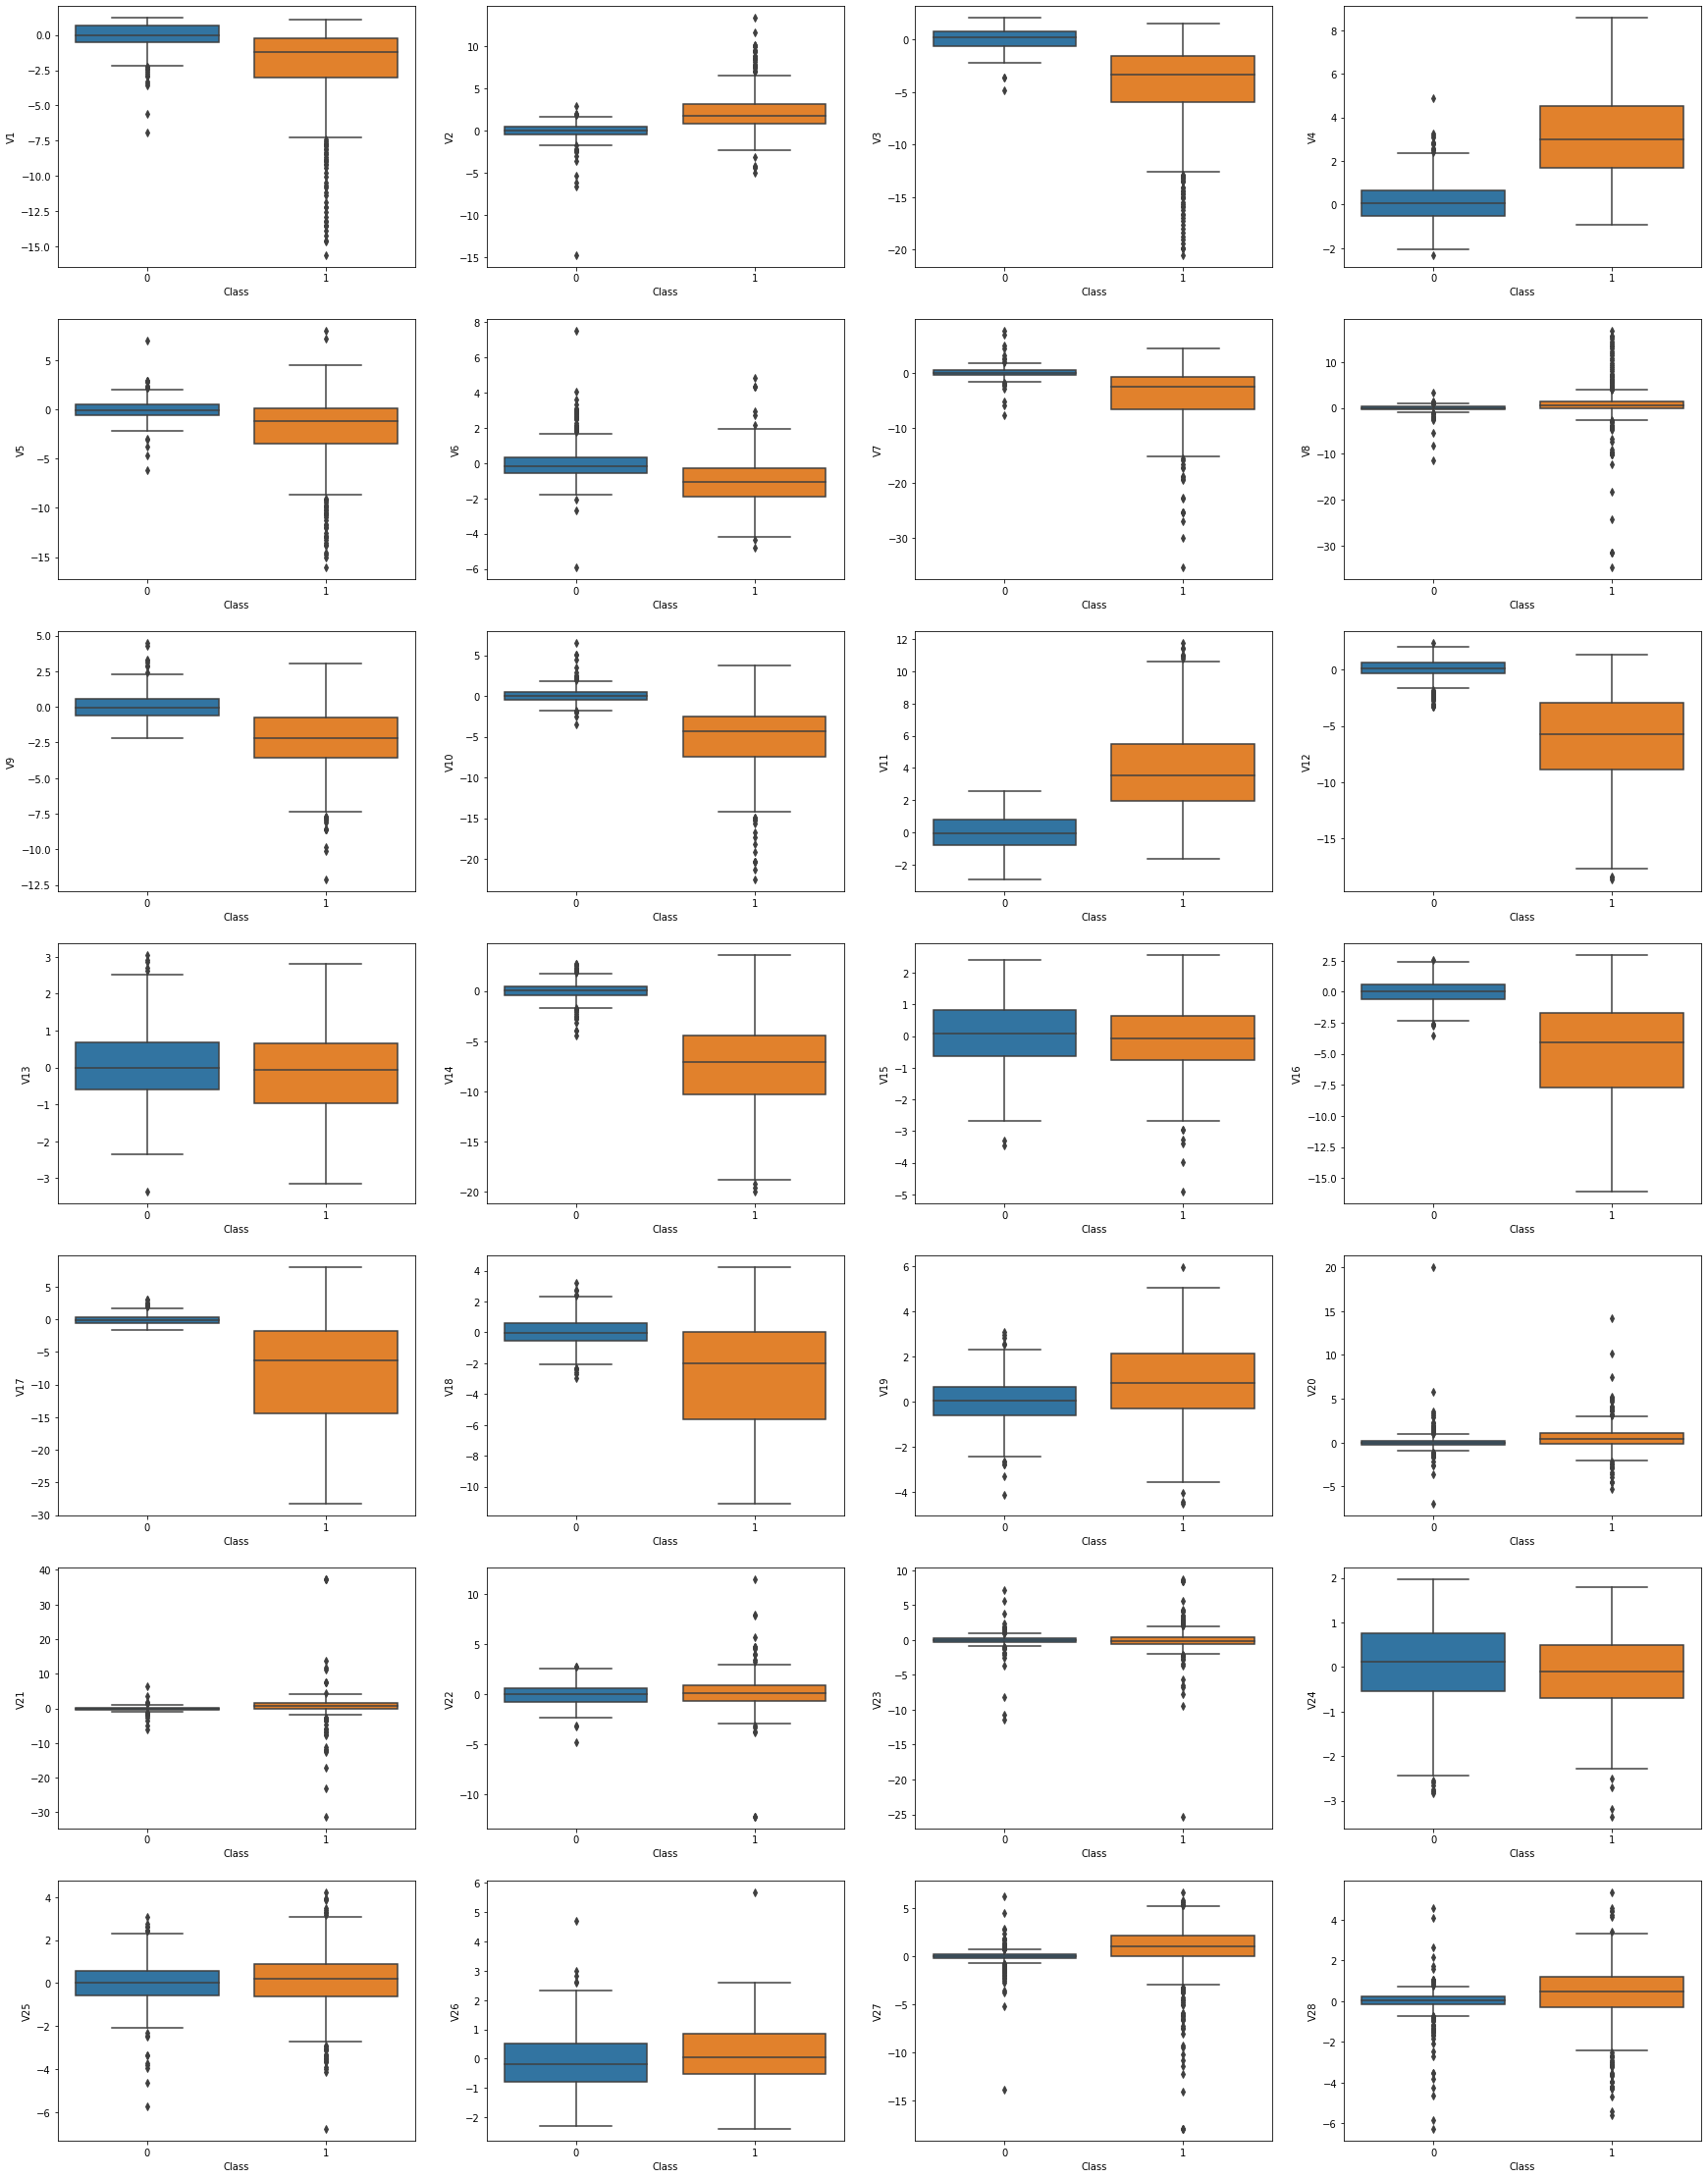

In [0]:
fig, axs = plt.subplots(7, 4, figsize=(30,40))

for i in range(0,7):
  sns.boxplot(x='Class', y='V'+str(i*4+1), data=undersample_df, ax=axs[i, 0])
  sns.boxplot(x='Class', y='V'+str(i*4+2), data=undersample_df, ax=axs[i, 1])
  sns.boxplot(x='Class', y='V'+str(i*4+3), data=undersample_df, ax=axs[i, 2])
  sns.boxplot(x='Class', y='V'+str(i*4+4), data=undersample_df, ax=axs[i, 3])
plt.show()

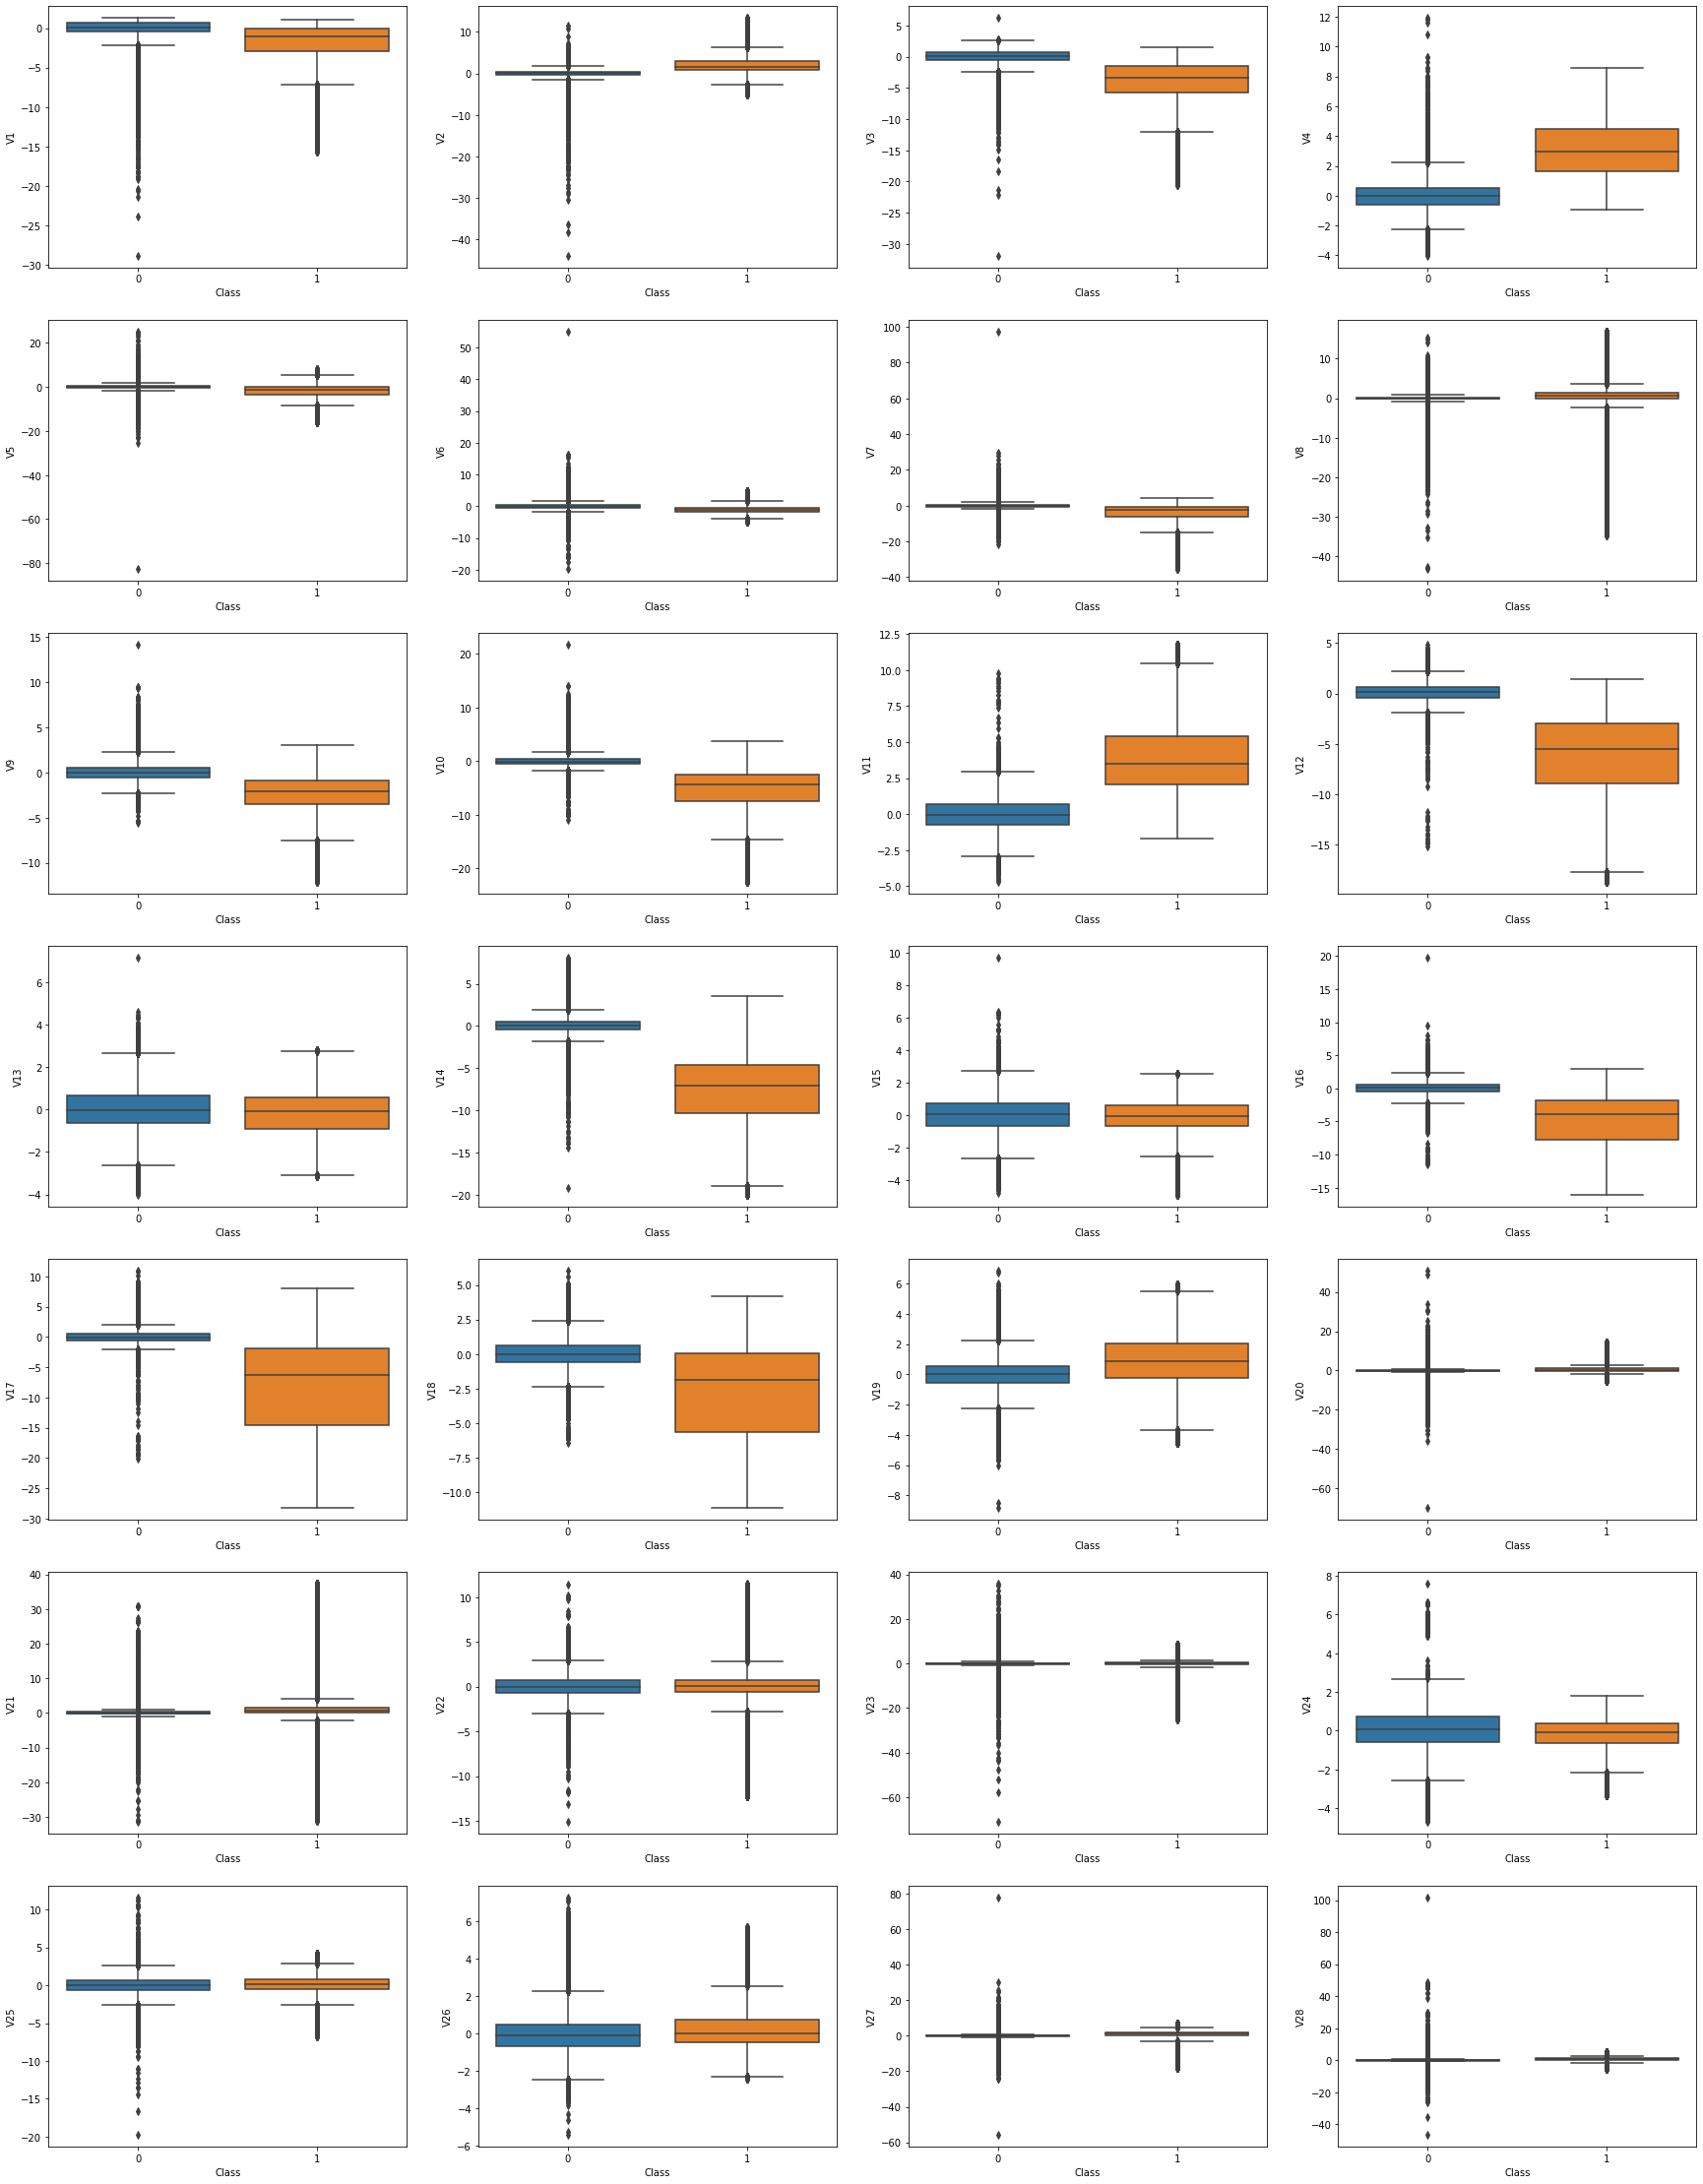

In [0]:
fig, axs = plt.subplots(7, 4, figsize=(30,40))

for i in range(0,7):
  sns.boxplot(x='Class', y='V'+str(i*4+1), data=oversample_df, ax=axs[i, 0])
  sns.boxplot(x='Class', y='V'+str(i*4+2), data=oversample_df, ax=axs[i, 1])
  sns.boxplot(x='Class', y='V'+str(i*4+3), data=oversample_df, ax=axs[i, 2])
  sns.boxplot(x='Class', y='V'+str(i*4+4), data=oversample_df, ax=axs[i, 3])
plt.show()

**Conclusions from correlation matrix and boxplots**

The correlation matrix and the boxplots which were plotted from the oversampled and undersampled datasets allow us to more accurately identify the correlation between the variables and the (fraud) Class.

Variables with Negative Correlation: V10, V12, V14, V16, and V17 are negatively correlated against Class.

Variables with Positive Correlation: V2, V4, and V11 are positively correlated against Class.

The remaining variables do not exhibit a strong correlation with Class.


# **Machine Learning & Evaluating our Model**

\begin{align*}
Precision = TP / (TP+FP)
\end{align*}

Precision tells us out of all the transactions we predicted as fraudulent, what percentage was actually fraudulent. This metric is important in our model as we want to reduce the number of times transactions are rejected because they were wrongly predicted as being fraudulent. However, recall will be a more important metric, as explained below.


\begin{align*}
Recall = TP / (TP+FN)
\end{align*}

Recall tells us out of all the fraudulent transactions, what percentage was correctly identified by our model. This metric is more important than precision, as it is more crucial to detect fraudulent transactions and not let them slip by, than reducing the number of false positives detected. A false positive might cause some hassle for consumers, possibly by requesting a verification of the user's identity. However a false negative has more dire consequences as it could lead to large monetary losses for both users and retailers.


\begin{align*}
F1 Score = 2* (Recall * Precision) / (Recall + Precision)
\end{align*}

F1 Score combines both recall and precision and returns a weighted average of the two. This takes both false positives and false negatives into consideration, and is much more useful as an indicator of the model's performance than accuracy, especially because of the highly skewed data. To elaborate, if our model guessed that none of the transactions were fraudulent, we would still achieve a 99.83% accuracy, as such using accuracy would not be useful in such a skewed data.

Hence, we decide to use F1 score to evaluate our model.


\begin{align*}
Macro Average = \frac{F1Score(0) + F1Score(1)}{2}
\end{align*}

#**Supervised Learning**

We try multiple supervised learning algorithms to pick which algorithm we should finetune.

We picked several popular algorithms.

**Logistic Regression** - Uses a logistic function to predict the probability of a transaction belonging to a certain class.

**K Nearest Neighbours**- Iteratively update and reclassify transactions into two different clusters.

**Decision Tree** - A series of if-else decisions to classify transactions

**LightGBM** - Gradient boosted tree-based algorithm that builds upon the errors of the previous trees.

**Random Forest** - Build multiple, independent decision trees with subsets of data and subsets of variables.

In [0]:
model_names = ["Logistic Regression", "K Nearest Neighbours", "Decision Tree", "LightGBM", "Random Forest"]
models = [LogisticRegression(), KNeighborsClassifier(n_neighbors=2), DecisionTreeClassifier(), lgb.LGBMClassifier(n_estimators=100, random_state = 42), RandomForestClassifier(n_estimators =10)]
model_saved = []

for i in range(len(models)):
  print("===== " + model_names[i] + " =====")
  undersample_model = models[i]
  oversample_model = models[i]
  start = timeit.default_timer()
  undersample_model.fit(undersample_df.drop('Class', axis=1), undersample_df['Class'])
  undersample_preds = undersample_model.predict(test_df.drop('Class', axis=1))
  if i ==4:
    for j in range(len(undersample_preds)):
      if undersample_preds[j]>=.5: # setting threshold to .5
        undersample_preds[j]=1
      else:
        undersample_preds[j]=0
  print("Confusion Matrix for Undersample Dataset")
  print(confusion_matrix(test_df['Class'], undersample_preds))
  print("Classification Report for Undersample Dataset")
  print(classification_report(test_df['Class'], undersample_preds))
  stop = timeit.default_timer()
  print('Time: ', stop - start) 

  start = timeit.default_timer()
  oversample_model.fit(oversample_df.drop('Class', axis=1), oversample_df['Class'])
  oversample_preds = oversample_model.predict(test_df.drop('Class', axis=1))
  if i ==4:
    for j in range(len(oversample_preds)):
      if oversample_preds[j]>=.5: # setting threshold to .5
        oversample_preds[j]=1
      else:
        oversample_preds[j]=0
  print("Confusion Matrix for Oversample Dataset")
  print(confusion_matrix(test_df['Class'], oversample_preds))
  print("Classification Report for Oversample Dataset")
  print(classification_report(test_df['Class'], oversample_preds))
  stop = timeit.default_timer()
  print('Time: ', stop - start)

  model_saved.append(oversample_model)



===== Logistic Regression =====
Confusion Matrix for Undersample Dataset
[[53610  3254]
 [    7    91]]
Classification Report for Undersample Dataset


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962

Time:  0.25975583599938545


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix for Oversample Dataset
[[53768  3096]
 [    7    91]]
Classification Report for Oversample Dataset
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.93      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.95      0.97     56962

Time:  103.23901509800089
===== K Nearest Neighbours =====
Confusion Matrix for Undersample Dataset
[[56012   852]
 [   10    88]]
Classification Report for Undersample Dataset
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962

Time:  9.823069385000053
Confusion Matrix for Oversam

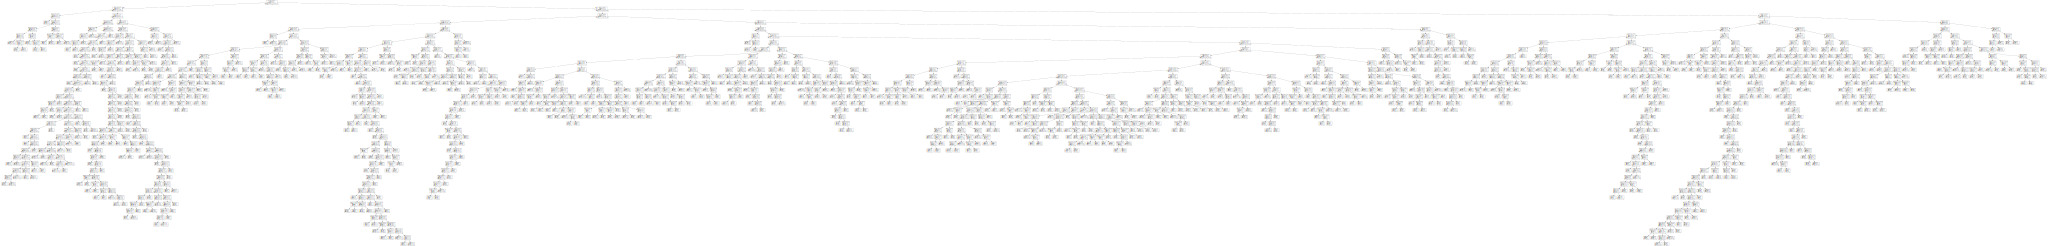

In [0]:
# Graph of Oversampled Tree
oversample_tree_graph = graphviz.Source(tree.export_graphviz(model_saved[2]))  
oversample_tree_graph

**Oversampled Dataset seems to work better**

Random Forest Classifier achieved the highest F1 score.

**Determine most important feature**

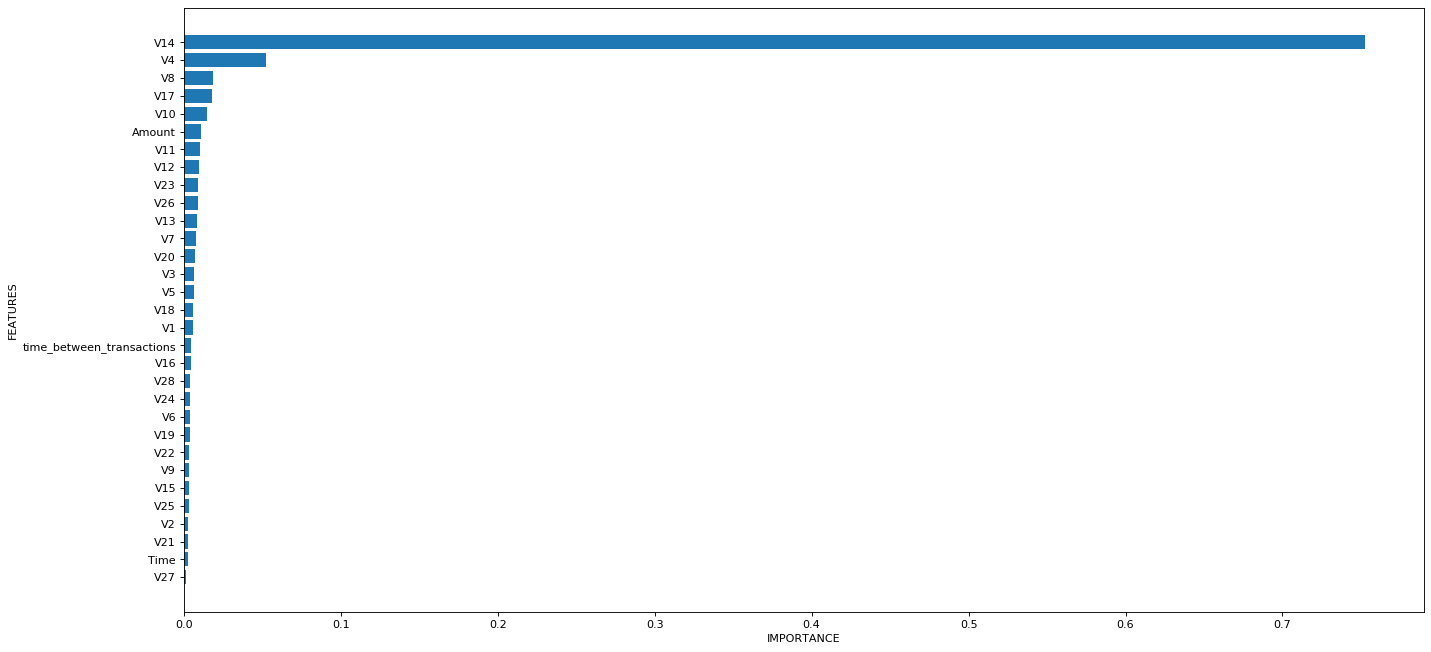

In [0]:
feat_labels = oversample_df.drop('Class', axis=1).columns
D = {}
for feature in zip(feat_labels, model_saved[2].feature_importances_):
    D[feature[0]] = feature[1]

D = dict(sorted(D.items(), key=lambda kv: kv[1]))

for k in list(D):
  if D[k] == 0:
    del D[k]

plt.figure(num=1, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.barh(range(len(D)), list(D.values()), align='center')
plt.yticks(range(len(D)), list(D.keys()))
plt.ylabel("FEATURES")
plt.xlabel("IMPORTANCE")
plt.show()

**Fitting with most important features**

In [0]:
D = sorted(D.items(), key=lambda x: x[1])
important_cols = []
for key, value in D[-20:]:
  important_cols.append(key)
important_cols.extend(['Class'])

In [0]:
extracted_df = oversample_df[important_cols]
new_test_df = test_df.copy()
new_test_df = test_df[important_cols]

start = timeit.default_timer()
extracted_model = RandomForestClassifier(n_estimators =10)
extracted_model.fit(extracted_df.drop('Class', axis=1), extracted_df['Class'])
oversample_preds = extracted_model.predict(new_test_df.drop('Class', axis=1))
print("Confusion Matrix for Oversample Dataset")
print(confusion_matrix(new_test_df['Class'], oversample_preds))
print("Classification Report for Oversample Dataset")
print(classification_report(new_test_df['Class'], oversample_preds))
stop = timeit.default_timer()
print('Time: ', stop - start)

Confusion Matrix for Oversample Dataset
[[56853    11]
 [   21    77]]
Classification Report for Oversample Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.79      0.83        98

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Time:  22.91241747499953


# **AUC - ROC curve**


In [0]:
from sklearn.metrics import roc_curve
roc_curve(test_df['Class'],  model_saved[0].predict_proba(test_df.drop('Class', axis=1))[:,1], pos_label=1)
roc_auc_score(test_df['Class'], model_saved[0].predict_proba(test_df.drop('Class', axis=1))[:,1])

0.9853199685895744

In [0]:
model_saved[0].__class__.__name__

'LogisticRegression'

In [0]:
from sklearn.metrics import roc_curve

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Record the results
for model in model_saved:
    yproba = model.predict_proba(test_df.drop('Class', axis=1))[:,1]
    fpr, tpr, _ = roc_curve(test_df['Class'],  yproba, pos_label=1)
    # precision, recall, _ = precision_recall_curve(y_test, y_score_rf)
    auc = roc_auc_score(test_df['Class'], yproba)
    
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

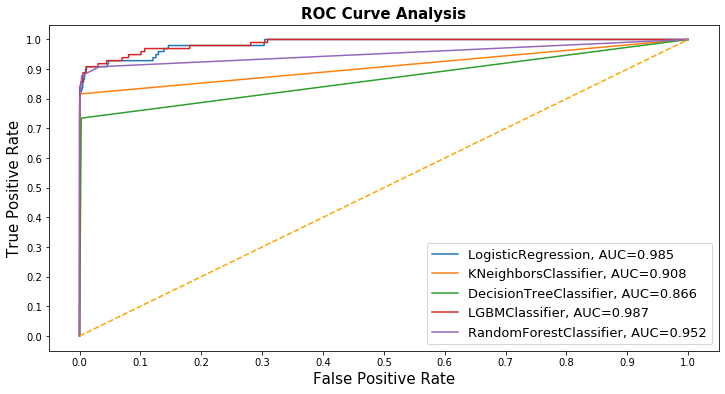

In [0]:
fig = plt.figure(figsize=(12,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# **AUC - Precision Recall curve**

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Define a result table as a DataFrame
result_table_1 = pd.DataFrame(columns=['classifiers', 'precision','recall', 'auc'])

# Record the results
for model in model_saved:
    yproba = model.predict_proba(test_df.drop('Class', axis=1))[:,-1]
    precision, recall, _ = precision_recall_curve(test_df['Class'], yproba)
    area = auc(recall, precision)

    result_table_1 = result_table_1.append({'classifiers':model.__class__.__name__,
                                        'precision':precision, 
                                        'recall':recall,
                                        'auc':area}, ignore_index=True)

# Set name of the classifiers as index labels
result_table_1.set_index('classifiers', inplace=True)

In [0]:
for i in result_table_1.index:
    plt.plot(result_table_1.loc[i]['recall'], 
             result_table_1.loc[i]['precision'], 
             label="{}, AUC={:.3f}".format(i, result_table_1.loc[i]['auc']))
    
plt.plot([0,1], [0.5,0.5], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('PR Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# **Neural Network**

In [0]:
class roc(Callback):
    '''
    Updated on March 28 2019 to reflect new change in FastAI's Callback
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.total/self.batch_count)

In [0]:
cont_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',]

dep_var='Class'
procs=[ Normalize]

test = TabularList.from_df(test_df, cont_names=cont_names, procs=procs)
data = (TabularList.from_df(train_df, cont_names=cont_names , procs=procs,)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var)
                .add_test(test)
                .databunch())
learn = tabular_learner(data, layers=[200,100], ps=[0.2,0.04], emb_drop=0.06, 
                        metrics=[accuracy, roc()])#, callback_fns=AUROC)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 5.25E-02


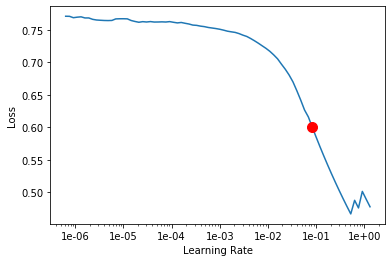

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(2,1e-02, wd=0.1, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='best')])

epoch,train_loss,valid_loss,accuracy,roc,time
0,0.004481,0.007139,0.999386,0.947838,00:23
1,0.002144,0.010307,0.999364,0.963294,00:23


Better model found at epoch 0 with valid_loss value: 0.007139337249100208.


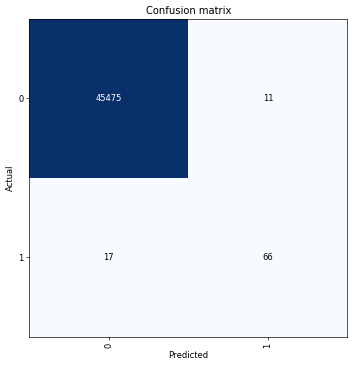

In [0]:
# From validation dataset
learn.load('best')
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [0]:
# Actual test set
valid_predicts, _ = learn.get_preds(ds_type=DatasetType.Test)
valid_probs = np.array(valid_predicts[:,1])
valid_targets = test_df.Class.values
valid_score = roc_auc_score(valid_targets, valid_probs)
print(valid_score)

from sklearn.metrics import classification_report, confusion_matrix

y_hat = np.argmax(valid_predicts,axis=1)
print(confusion_matrix(valid_targets, y_hat))
print(classification_report(valid_targets, y_hat))

0.9648689174600623
[[56841    23]
 [   23    75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.77      0.77        98

    accuracy                           1.00     56962
   macro avg       0.88      0.88      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [0]:
fpr, tpr, _ = roc_curve(valid_targets, valid_probs)
auc = roc_auc_score(valid_targets, valid_probs)

result_table = result_table.append({'classifiers':"Neural Network",
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

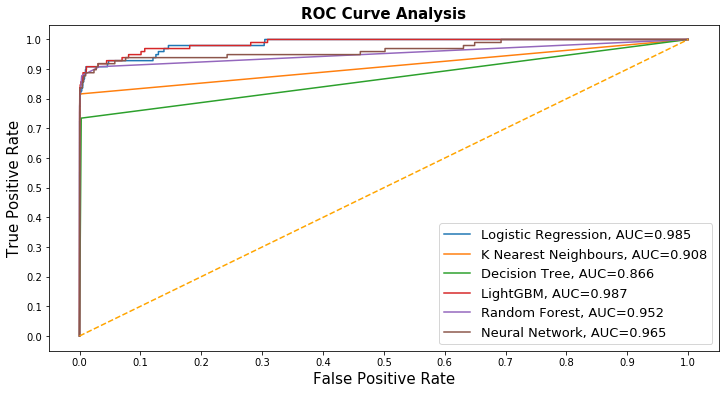

In [0]:
result_table.index = ["Logistic Regression", "K Nearest Neighbours", "Decision Tree", "LightGBM", "Random Forest", "Neural Network"]
fig = plt.figure(figsize=(12,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [0]:
valid_predicts, _ = learn.get_preds(ds_type=DatasetType.Test)
valid_probs = np.array(valid_predicts[:,1])
precision, recall, _ = precision_recall_curve(test_df['Class'], valid_probs)
area = auc(recall, precision)
result_table_1 = result_table_1.append({'classifiers':"Neural Network",
                                        'precision':precision, 
                                        'recall':recall,
                                        'auc':area}, ignore_index=True)  

In [0]:
result_table_1 = result_table_1.drop(6, axis=0)

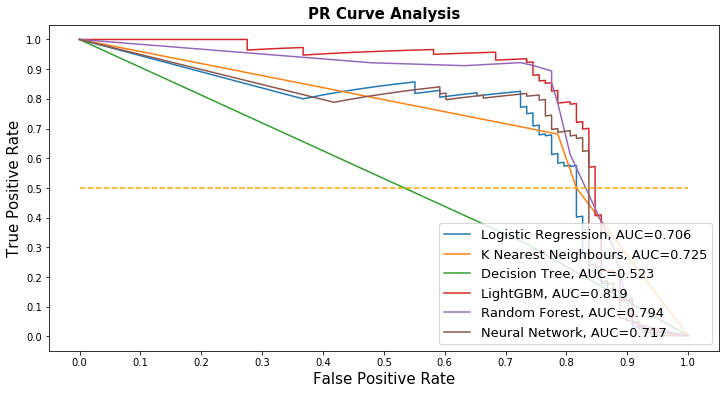

In [0]:
result_table_1.index = ["Logistic Regression", "K Nearest Neighbours", "Decision Tree", "LightGBM", "Random Forest", "Neural Network"]
fig = plt.figure(figsize=(12,6))
for i in result_table_1.index:
    plt.plot(result_table_1.loc[i]['recall'], 
             result_table_1.loc[i]['precision'], 
             label="{}, AUC={:.3f}".format(i, result_table_1.loc[i]['auc']))
    
plt.plot([0,1], [0.5,0.5], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('PR Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()